![Image of Yaktocat](https://d12x8xcsuwjfth.cloudfront.net/img/usr/second/k_b_01.jpg)

<font color=black size=6 face=雅黑>**Table of Contents**</font>

1  データの読み込み  
&emsp; 1.1  trainデータとtestデータを結合  
2  前処理  
&emsp; 2.1  欠損処理  
&emsp; 2.2  特徴量の作成  
&emsp; 2.3  One-Hotエンコ―ディング  
3  モデル作成  
&emsp; 3.1  trainデータとtestデータに分ける  
&emsp; 3.2  不要なカラムを捨てる  
&emsp; 3.3  線形回帰モデルの作成（LinearRegression）  
&emsp; 3.4  アンサンブル学習（RandomForestRegressor）  
&emsp; 3.5  RMSE評価  
4  testデータの予測と予測値の導出

## 1 データの読み込み

In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
sns.set(font="IPAexGothic",style="white")

from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error as MSE

In [3]:
# 日付のカラムをインデックスとして取り込み
train = pd.read_csv('train.csv',index_col=['datetime'])
test = pd.read_csv('test.csv',index_col=['datetime'])
sample = pd.read_csv('sample.csv', header=None)

In [4]:
train.tail()

,y,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
datetime,,,,,,,,,,,
2014/9/24,59,水,1,白身魚のマスタード焼き,408.0,NaN,NaN,NaN,曇,0,24.8
2014/9/25,50,木,0,牛カルビ焼き肉,394.0,NaN,NaN,NaN,曇,0,25.4
2014/9/26,45,金,0,ランチビュッフェ,NaN,スペシャルメニュー（800円）,キャリアアップ支援セミナー,NaN,晴れ,--,27.1
2014/9/29,56,月,1,豚肉と玉子の炒め,404.0,NaN,NaN,NaN,快晴,--,26.6
2014/9/30,40,火,0,鶏肉とカシューナッツ炒め,398.0,NaN,NaN,NaN,快晴,--,28.1


In [5]:
test.head()

,week,soldout,name,kcal,remarks,event,payday,weather,precipitation,temperature
datetime,,,,,,,,,,
2014/10/1,水,1,メンチカツ,420.0,NaN,NaN,NaN,雨,0,20.2
2014/10/2,木,0,バーベキューチキン,415.0,NaN,NaN,NaN,曇,--,23.9
2014/10/3,金,0,豚肉のマスタード焼き,405.0,NaN,NaN,NaN,晴れ,--,28.7
2014/10/6,月,1,麻婆春雨,400.0,NaN,NaN,NaN,雨,0.5,21.5
2014/10/7,火,0,厚揚げ肉みそ炒め,430.0,NaN,NaN,NaN,晴れ,--,22.1


In [6]:
# 行数,カラム数
print(train.shape, test.shape)

(207, 11) (40, 10)


In [7]:
# 使用する変数の和訳
list_dic = {"変数" : ["datetid", "y", "soldout", "Age", "name", "kcal", "remarks", "event", "payday", "weather", "precipitation", "temperature"],
            "和訳" : ["日付", "販売数", "曜日", "完売", "メインメニューの名前", "カロリー", "特記事項", "イベント", "給料日", "天気", "降水量", "気温"]}
pd.DataFrame(list_dic)

,変数,和訳
0,datetid,日付
1,y,販売数
2,soldout,曜日
3,Age,完売
4,name,メインメニューの名前
5,kcal,カロリー
6,remarks,特記事項
7,event,イベント
8,payday,給料日
9,weather,天気


### 1.1 trainデータとtestデータを結合

In [8]:
# フラグを立てる
train['flg'] = 1
test['flg'] = 0

# trainデータとtestデータを結合
all_data = pd.concat([train,test], axis=0, sort=False)

In [9]:
# 欠損数、型確認
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 247 entries, 2013/11/18 to 2014/11/28
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   y              207 non-null    float64
 1   week           247 non-null    object 
 2   soldout        247 non-null    int64  
 3   name           247 non-null    object 
 4   kcal           202 non-null    float64
 5   remarks        28 non-null     object 
 6   event          17 non-null     object 
 7   payday         12 non-null     float64
 8   weather        247 non-null    object 
 9   precipitation  247 non-null    object 
 10  temperature    247 non-null    float64
 11  flg            247 non-null    int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 25.1+ KB


## 2 前処理

### 2.1 欠損処理

#### カロリーの欠損値は平均値で埋める

In [10]:
all_data['kcal'] = all_data['kcal'].fillna(train['kcal'].mean())
all_data['kcal'].head()

datetime
2013/11/18    404.409639
2013/11/19    404.409639
2013/11/20    404.409639
2013/11/21    404.409639
2013/11/22    404.409639
Name: kcal, dtype: float64

#### 給料日=1なので、欠損値は0で埋める

In [11]:
all_data['payday'] = all_data['payday'].fillna(0)
all_data['payday'].unique()

array([0., 1.])

#### イベントの欠損値は「なし」で埋める

In [12]:
all_data['event'] = all_data['event'].fillna('なし')
all_data['event'].unique()

array(['なし', 'ママの会', 'キャリアアップ支援セミナー'], dtype=object)

#### 特記事項

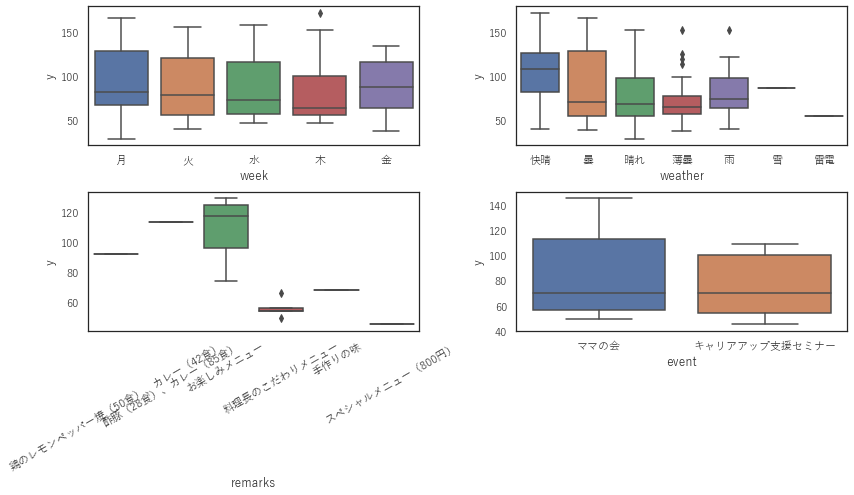

In [13]:
# 日本語フォントを入れる。
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Hiragino Maru Gothic Pro', 'Yu Gothic', 'Meirio', 'Takao', 'IPAexGothic', 'IPAPGothic', 'Noto Sans CJK JP']

# 目的変数と説明変数の関係を箱ひげ図で確認（カテゴリ変数のみ）。
fig, ax = plt.subplots(2,2,figsize=(12,7))
sns.boxplot(x="week",y="y",data=train,ax=ax[0][0])
sns.boxplot(x="weather",y="y",data=train,ax=ax[0][1])
sns.boxplot(x="remarks",y="y",data=train,ax=ax[1][0])
ax[1][0].set_xticklabels(ax[1][0].get_xticklabels(),rotation=30)
sns.boxplot(x="event",y="y",data=train,ax=ax[1][1])
plt.tight_layout()

In [14]:
# お楽しみメニューでないときは「なし」で埋める。
all_data.loc[all_data['remarks'] != 'お楽しみメニュー', 'remarks'] = 'なし'
all_data['remarks'].unique()

array(['なし', 'お楽しみメニュー'], dtype=object)

#### 欠損が埋まったか確認

In [15]:
all_data.info()

<class 'pandas.core.frame.DataFrame'>
Index: 247 entries, 2013/11/18 to 2014/11/28
Data columns (total 12 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   y              207 non-null    float64
 1   week           247 non-null    object 
 2   soldout        247 non-null    int64  
 3   name           247 non-null    object 
 4   kcal           247 non-null    float64
 5   remarks        247 non-null    object 
 6   event          247 non-null    object 
 7   payday         247 non-null    float64
 8   weather        247 non-null    object 
 9   precipitation  247 non-null    object 
 10  temperature    247 non-null    float64
 11  flg            247 non-null    int64  
dtypes: float64(4), int64(2), object(6)
memory usage: 25.1+ KB


### 2.2 特徴量の作成

#### 降水量

In [16]:
# 降水量が--の時
print("降水量が--の時：" + '、'.join(all_data[all_data['precipitation'] == "--"]['weather'].unique()))

# 降水量が0の時
print("降水量が0の時：" + '、'.join(all_data[all_data['precipitation'] == "0"]['weather'].unique()))

# 降水量に数値が入っている時
print("降水量に数値が入っている時：" + '、'.join(all_data[~(all_data['precipitation'] == '0') & ~(all_data['precipitation'] == '--')]['weather'].unique()))

降水量が--の時：快晴、曇、晴れ、薄曇
降水量が0の時：雨、曇、雷電、薄曇
降水量に数値が入っている時：曇、雨、雪


In [17]:
# precipitation_flg(カテゴリ変数)を作る。
# 降水量が--の時、「快晴、曇、晴れ、薄曇」→「天気が良い」とみなし「良い」で埋める。  
# 降水量が0の時、「雨、曇、雷電、薄曇」→「あまり天気が良くない」とみなし「やや悪い」で埋める。  
# 降水量に数値が入っている時、「曇、雨、雪」→「天気が悪い」とみなし「悪い」で埋める。
all_data['precipitation_flg'] = '悪い'
all_data.loc[(all_data['precipitation'] == '--'), 'precipitation_flg'] = '良い'
all_data.loc[(all_data['precipitation'] == '0'), 'precipitation_flg'] = 'やや悪い'

In [18]:
# 文字列を数値データに変える(量的変数)
all_data['precipitation'] = all_data['precipitation'].replace('--', '-1')

#### 経過日数カラム

<AxesSubplot:xlabel='datetime'>

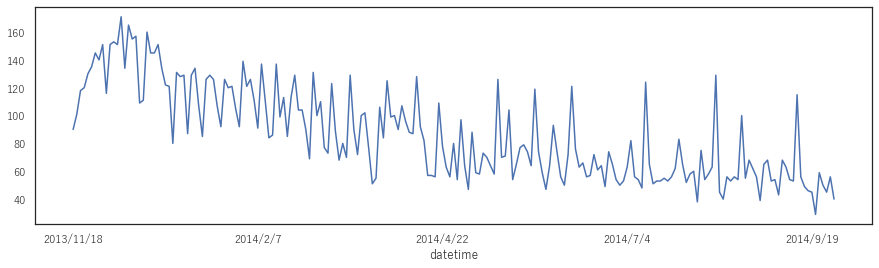

In [19]:
# お弁当の売り上げ分布の確認。  
train["y"].plot(figsize=(15,4))

# 日数が経過するにつれて売り上げが落ちていく傾向＝線形な関係がある。  
# ただし所々急増するところがあるため為、売り上げ数に寄与している何かしらの要因がある。

In [20]:
# 日付の経過と関係が深いため、連番の数値を入れた経過日数カラムを作る。
all_data['days'] = range(1,len(all_data)+1)

### 2.3 One-Hotエンコ―ディング

カテゴリデータをOhe-Hot表現にする。  
適用出来るカラムは  
・一意の値が少ないもの  
・カテゴリ変数であるもの（＝量的変数でないもの） 

In [21]:
# 各カラムの一意の値を見る。
for col in all_data.columns:
    print(col,all_data[col].unique())
    print(all_data[col].nunique())
    print('----------------------------------------------')

y [ 90. 101. 118. 120. 130. 135. 145. 140. 151. 116. 153. 171. 134. 165.
 155. 157. 109. 111. 160. 122. 121.  80. 131. 128. 129.  87. 107.  85.
 126.  92. 105. 139.  91. 137.  84.  86.  99. 113. 104.  69. 100. 110.
  77.  73. 123.  89.  68.  70.  72. 102.  51.  55. 106. 125.  96.  88.
  82.  57.  56.  78.  63.  54.  97.  64.  47.  59.  58.  71.  65.  79.
  74. 119.  93.  50.  76.  66.  61.  49.  53.  48. 124.  62.  83.  52.
  60.  38.  75.  45.  40.  39.  43. 115.  46.  29.  nan]
94
----------------------------------------------
week ['月' '火' '水' '木' '金']
5
----------------------------------------------
soldout [0 1]
2
----------------------------------------------
name ['厚切りイカフライ' '手作りヒレカツ' '白身魚唐揚げ野菜あん' '若鶏ピリ辛焼' 'ビッグメンチカツ' '鶏の唐揚' '豚のスタミナ炒め'
 'ボローニャ風カツ' 'ハンバーグ' 'タルタルinソーセージカツ' 'マーボ豆腐' '厚揚げ豚生姜炒め' 'クリームチーズ入りメンチ'
 '鶏のカッシュナッツ炒め' '手作りロースカツ' 'ハンバーグデミソース' 'やわらかロースのサムジョン' '五目御飯' '肉じゃが'
 'タンドリーチキン' 'カキフライタルタル' '回鍋肉' 'ポーク味噌焼き' '鶏の唐揚げ甘酢あん' 'さっくりメンチカツ'
 '手ごね風ハンバーグ' '酢豚' 'カレー入りソーセージカツ' '豚肉の生姜焼' '鶏チ

In [22]:
# 「曜日,完売,特記事項,イベント,給料日,天気,降水量フラグ」をOne-Hotする。
one_columns = ['week','soldout','remarks','event','payday','weather','precipitation_flg']

all_data = pd.get_dummies(all_data, dummy_na=False, columns=one_columns)

## 3 モデル作成

### 3.1 trainデータとtestデータに分ける

In [23]:
# trainとtestに分ける
train = all_data.query('flg == 1')
test = all_data.query('flg == 0')

### 3.2 不要なカラムを捨てる

捨てるカラム  
・結合した際testデータに作られたyカラム  
・結合に使ったflgカラム  
・一意の値が多く、One-Hot出来ないnameカラム 

In [24]:
train.drop(['flg','name'], axis=1,inplace=True)
test.drop(['flg','name','y'], axis=1,inplace=True)

<ipython-input-24-1b08160c1abb>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train.drop(['flg','name'], axis=1,inplace=True)
<ipython-input-24-1b08160c1abb>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test.drop(['flg','name','y'], axis=1,inplace=True)


In [25]:
train.head()

,y,kcal,precipitation,temperature,days,week_月,week_木,week_水,week_火,week_金,...,weather_快晴,weather_晴れ,weather_曇,weather_薄曇,weather_雨,weather_雪,weather_雷電,precipitation_flg_やや悪い,precipitation_flg_悪い,precipitation_flg_良い
datetime,,,,,,,,,,,,,,,,,,,,,
2013/11/18,90.0,404.409639,-1,19.8,1,1,0,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2013/11/19,101.0,404.409639,-1,17.0,2,0,0,0,1,0,...,1,0,0,0,0,0,0,0,0,1
2013/11/20,118.0,404.409639,-1,15.5,3,0,0,1,0,0,...,1,0,0,0,0,0,0,0,0,1
2013/11/21,120.0,404.409639,-1,15.2,4,0,1,0,0,0,...,1,0,0,0,0,0,0,0,0,1
2013/11/22,130.0,404.409639,-1,16.1,5,0,0,0,0,1,...,1,0,0,0,0,0,0,0,0,1


### 3.3 線形回帰モデルの作成（LinearRegression）

In [26]:
# trainデータの説明変数と目的変数をわける
X_train = train[["days", "temperature", "kcal", "remarks_お楽しみメニュー", "remarks_なし"
                       ,"week_月", "week_火", "week_水", "week_木", "week_金", "weather_雨","soldout_1"
                      ,"precipitation_flg_やや悪い","precipitation_flg_悪い"]]

# 目的変数はLinear,RandomForest共通
y_train = train['y']

# testデータもlinear_X_trainと同じカラムにする
X_test = test[["days", "temperature", "kcal", "remarks_お楽しみメニュー", "remarks_なし"
                       ,"week_月", "week_火", "week_水", "week_木", "week_金", "weather_雨","soldout_1"
                      ,"precipitation_flg_やや悪い","precipitation_flg_悪い"]]

In [27]:
# LinearRegressionのパラメータ設定
linear = LinearRegression()

# 線形回帰モデル作成
linear.fit(X_train,y_train)

# 予測
pred = linear.predict(X_train)

RMSE 16.18375891560382


<AxesSubplot:xlabel='datetime'>

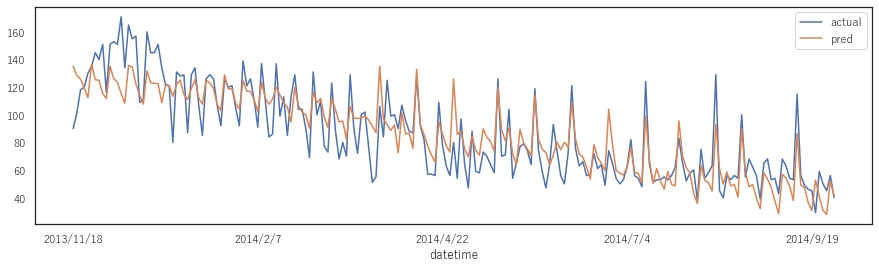

In [28]:
# y_trainと予測値のRMSEを出す
print("RMSE",np.sqrt(MSE(y_train,pred)))

# 線形回帰の予測値と実数値のグラフ
p = pd.DataFrame({"actual":y_train,"pred":pred})
p.plot(figsize=(15,4))

### 3.4 アンサンブル学習（RandomForestRegressor）

LinearRegressionで予測した結果の残差を目的変数として学習し、  
予測値を補正する為の非線形なモデルとしてRandomForestを使う。

In [29]:
# RandomForestのパラメータ設定
randomforest = RandomForestRegressor(n_estimators=100,max_depth=12,random_state=2018)

# 残差 = 実測値 - 予測値 を求める
pred_sub = y_train - pred

# RandomForestの説明変数には全てのカラムを使う
randomforest_X_train = train.drop(['y'],axis=1)

# randomforest_X_trainを説明変数、pred_sub（残差）を目的変数にし、モデル作成
randomforest.fit(randomforest_X_train,pred_sub)

RandomForestRegressor(max_depth=12, random_state=2018)

In [30]:
# 線形回帰の予測値に、RandomForestで予測した残差を足し合わせたものを、最終的な予測値とする
pred = linear.predict(X_train) + randomforest.predict(randomforest_X_train)

### 3.5 RMSE評価

RMSE 5.15862262692792


<AxesSubplot:xlabel='datetime'>

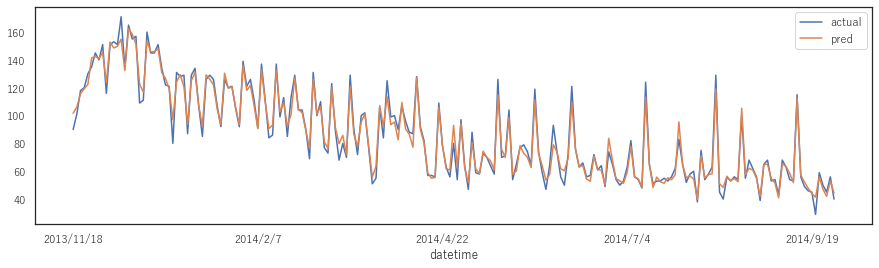

In [31]:
# アンサンブル学習後のRMSE
print("RMSE",np.sqrt(MSE(y_train,pred)))

# アンサンブル学習後の予測値と実数値のグラフ
p = pd.DataFrame({"actual":y_train,"pred":pred})
p.plot(figsize=(15,4))

## 4 testデータの予測と予測値の導出

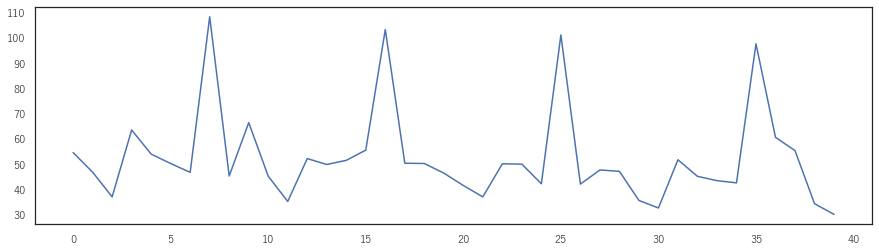

In [32]:
# testデータを予測する。
pred2 = linear.predict(X_test) + randomforest.predict(test)
plt.figure(figsize=(15,4))
plt.plot(pred2)

In [33]:
# 予測値を導出する。
sample[1] = pred2
sample.to_csv("submit01.csv",index=None,header=None)